## Name: {James Chung}

## Homework 2: Algorithmic Bias and Fairness - COMPAS

**Disclaimer**: Notebook adapted by Robert Clements from [Algorithmic Fairness - Considering Different Definitions](https://github.com/ds-modules/data-4ac/tree/master/notebook4%20-%20COMPAS)

## Tools

#### Libraries:
  
- pandas and numpy: for data processing 
- seaborn and matplotlib: for plotting  
- sklearn metrics: for roc curves 
- aif360: for fairness assessment and mitigation

#### Datasets:

COMPAS 

## Table of Contents

* [1. COMPAS Exploration](#one)
* [2. Replicating ProPublica's Metrics](#two)
* [3. Replicating Northpointe's Refutal](#three)
* [4. Removing Disparity](#four)
* [5. Conclusion](#five)

## Goals

In this assignment we will explore fairness metrics through the very popular COMPAS dataset that we covered in class. We will look at a selection of the metrics that were computed from ProPublica and also Northpointe. From here, we will see how we can use the [AIF360 library](https://aif360.res.ibm.com/), created at IBM, for doing a form of bias correction on the COMPAS data.

## Setup

First, let's load the libraries. Remember to install any libraries not already installed. We will need `BlackBoxAuditing` for `aif360` to work.

In [2]:
!pip install -q aif360
!pip install -q BlackBoxAuditing
!pip install -q seaborn

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

# to be used for fairness mitigation
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import BinaryLabelDataset

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [37]:
%matplotlib inline

## 1. COMPAS Exploration <a id="one"></a>

In this section we will simply load the COMPAS data and do a quick exploration to better understand what it contains. This is the same dataset that ProPublica used. In order to follow ProPublica's analysis, we remove any cases where the charge was not within 30 days of the score (ProPublica did this in order to match the COMPAS score with the correct criminal case).

There are over 50 columns in the original dataset, but we can go ahead and filter out the columns not used by ProPublica. We will only keep these columns: age, severity of charge (Felony or Misdemeanor), race, compas score classification and actual score, sex, count of priors, and whether each person was accused of a crime within two years (proxy for recidivated).

In [98]:
# change this to your path
data_path = 'compas-scores-two-years.csv'

compas = pd.read_csv(data_path)
compas = compas.query('days_b_screening_arrest <= 30 & days_b_screening_arrest >= -30')

compas = compas[["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", 
                    "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"]]
compas['jail_time'] = compas['c_jail_out'].astype('datetime64') - compas['c_jail_in'].astype('datetime64')
compas['jail_days'] = compas['jail_time'].dt.days
compas.drop(['jail_time'], axis=1, inplace=True)
compas.head()

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out,jail_days
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,0
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53,10
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04,1
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,1
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30,6


Do a bit more exploration of the data on your own, for example look at distributions of age, race, sex, etc.. And then answer questions 1a, 1b, and 1c below.

Text(0.5, 1.0, 'avg Decile score by Age Group')

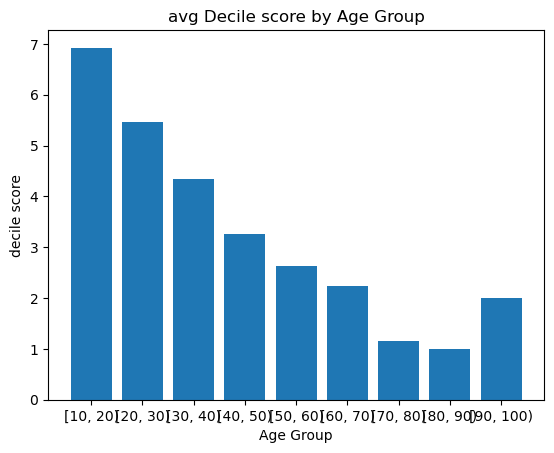

In [112]:
bins = range(0, compas['age'].max() + 10, 10)
compas['age_group'] = pd.cut(compas['age'], bins=bins, right=False)

# Group by age group and calculate mean jail_days
grouped = compas.groupby('age_group')['decile_score'].mean()

# Create bar plot
plt.bar(grouped.index.astype(str), grouped.values)

# Adding labels and title for clarity
plt.xlabel('Age Group')
plt.ylabel('decile score')
plt.title('avg Decile score by Age Group')

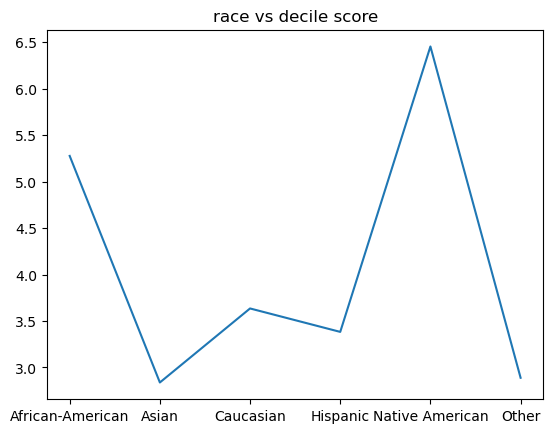

In [113]:
temp = compas[['race','decile_score']]
temp = temp.groupby('race').mean()
fig, ax = plt.subplots()
ax.plot(temp.index, temp['decile_score'])
ax.set_title('race vs decile score')
plt.show()

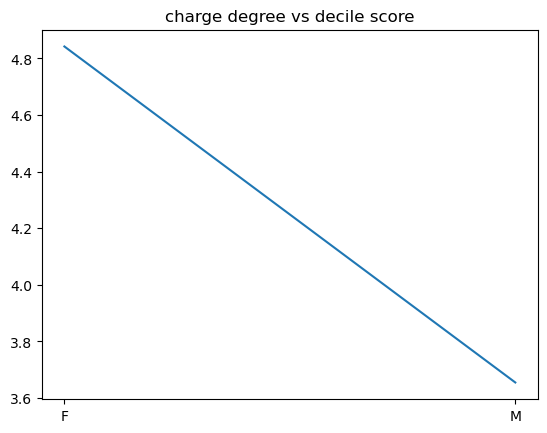

In [115]:
temp = compas[['c_charge_degree','decile_score']]
temp = temp.groupby('c_charge_degree').mean()
fig, ax = plt.subplots()
ax.plot(temp.index, temp['decile_score'])
ax.set_title('charge degree vs decile score')
plt.show()

<b>Question 1a:</b> Explain 3 parties that are impacted by the COMPAS tool. In what ways are they impacted? (Can you think of impacts beyond those in the courtroom for at least one of your examples?)

**Answer:** age, charge degree, race

<b>Question 1b:</b> Based on your initial reading, what is one problem of the criminal justice system that the COMPAS tool could potentially alleviate? What is one potential problem that using the COMPAS algorithm could introduce?

**Answer:** COMPAS tool can provide an objective metric of how much danger can a criminal pose, given that the model is an unbiased, fair model. However, if the model is inherently wrong, it can cause a severe problem. For example, undesired variables such as race might not only be positively correlated to decile score, but could be a direct causation of decile score.

***Sensitive features*** are features within a dataset that are given special consideration and treatment for potential legal, social, or ethical reasons. Often, these features are recognized and protected by antidiscrimination or privacy laws. One example of a sensitive feature is age. 

<b>Question 1c:</b> Identify all sensitive features in the filtered dataset.

**Answer:** age, sex

---

## 2. Replicating ProPublica's Metrics <a id="two"></a>

Let's retrace ProPublica's statistical analysis in order to better understand ProPublica's argument and engage with the metric of fairness that it uses. In order to mimic their analysis more closely, we will use ProPublica’s definitions of “high” and “low” scores: any score above a 4 is considered a high score, while 4 and below is considered a low score. ProPublica's use of 4 as a threshold is arguably low.

We can start by visualizing how ProPublica began their investigation of racial disparity within the COMPAS risk assessment. The histogram below displays the differences between the risk scores of black and white defendants.

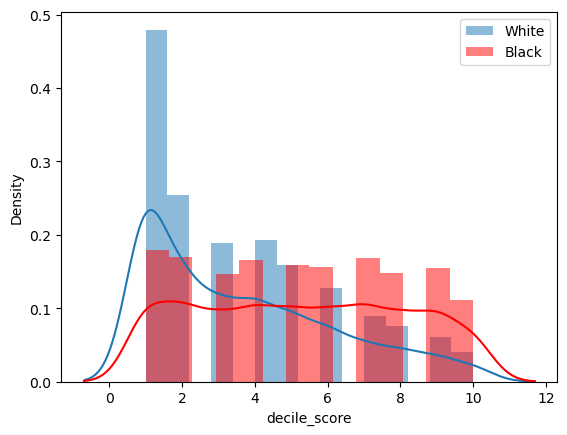

In [116]:
# Code to create a histogram for the risk scores for white defendants
white_data = compas[compas["race"] == "Caucasian"]
sns.histplot(white_data["decile_score"], kde=True, stat="density", kde_kws=dict(cut=3), linewidth=0, label = "White")

# Code to create a histogram for the risk scores for Black defendants
black_data = compas[compas["race"] == "African-American"]
sns.histplot(black_data["decile_score"], kde=True, stat="density", kde_kws=dict(cut=3), linewidth=0, color='r', label = "Black"); # This plot will layer over the previous plot

# Add legend
plt.legend()

# Adjust legend position
plt.legend(loc="upper right")

<b>Question 2a:</b> What do you notice about the score distributions?

**Answer:** White have exponential distribution, while black have uniform distribution. i.e. Compas acts no better than dice tossing for black.

---

ProPublica used the **False Positive Rate (FPR)** and **False Negative Rate (FNR)** as their metrics to understand and quantify fairness. In terms of COMPAS, the FPR tells us the percentage of defendants that do not reoffend that were labeled as "high risk" with a score above 4. On the other hand, the FNR tells us the percentage of defendants that do reoffend that were labeled as "low risk" with a score less than or equal to 4.

Please calculate the FPR and FNR for White and Black defendents together, and then separately.

In [117]:
def fpr(race_feature, data):
    # Function returns the False Positive Rate of scores for the specified race_feature
    
    subgroup = data[data["race"].isin(race_feature)]
    did_not_recidivate = subgroup[subgroup["two_year_recid"] == 0]

    false_positives = did_not_recidivate[did_not_recidivate["decile_score"] > 4].shape[0]
    true_negatives = did_not_recidivate[did_not_recidivate["decile_score"] <= 4].shape[0]
    return false_positives / (false_positives + true_negatives)


def fnr(race_feature, data):
    # Function returns the False Negative Rate of scores for the specified race_feature
    
    subgroup = data[data["race"].isin(race_feature)]
    recidivated = subgroup[subgroup["two_year_recid"] == 1]
    
    false_negatives = recidivated[recidivated["decile_score"] <= 4].shape[0]
    true_positives = recidivated[recidivated["decile_score"] > 4].shape[0]
    return false_negatives / (false_negatives + true_positives)

# Apply the metrics to the dataset and print out all results
print("FPR for Black and White defendants:", round(fpr(["African-American", "Caucasian"], compas), 5) * 100, "%")
print("FPR for Black defendants:", round(fpr(["African-American"], compas), 5) * 100, "%")
print("FPR for white defendants:", round(fpr(["Caucasian"], compas), 5) * 100, "%")
print("FNR for Black and White defendants:", round(fnr(["African-American", "Caucasian"], compas), 5) * 100, "%")
print("FNR for Black defendants:", round(fnr(["African-American"], compas), 4) * 100, "%")
print("FNR for white defendants:", round(fnr(["Caucasian"], compas), 5) * 100, "%")

FPR for Black and White defendants: 33.023 %
FPR for Black defendants: 42.338 %
FPR for white defendants: 22.014 %
FNR for Black and White defendants: 35.481 %
FNR for Black defendants: 28.48 %
FNR for white defendants: 49.635 %


<b>Question 2b:</b> What do you notice about the values of the two metrics that ProPublica chose to focus on, FPR and FNR? 

**Answer:** Higher FPR for black than white suggest that COMPAS could be favoring white. Similarly, Higher FNR for white also suggests that COMPAS could be favoring white.

<b>Question 2c:</b> Why might the values of these two metrics indicate a problem with the fairness of the COMPAS score? What real-life impact might they have?

**Answer:** Higher FPR implies that the convicted received a high decile score even though the convicted is unlikely to recidivate. On the contrary, higher FNR implies that the convicted received a low decile score even though the convicted is more likely to recidivate.

---

## 3. Replicating Northpointe's Refutation <a id="three"></a>

In the wake of criticism from ProPublica and other researchers alike, Northpointe produced a [detailed response](http://go.volarisgroup.com/rs/430-MBX-989/images/ProPublica_Commentary_Final_070616.pdf) to ProPublica’s allegations, claiming that these critiques of their tool utilized the wrong type of fairness metrics in their analysis and portrayed the tool incorrectly. The company provided their own analysis of the COMPAS algorithm by using different methods and responding individually to each of ProPublica’s claims of racial bias against Black defendants. 

Upon examining their tool’s fairness through a metric called *accuracy equity* (a metric that was left out of ProPublica’s analysis), as well as the fact that the model was not trained with a race feature, Northpointe concluded that their algorithm treats all people and specified groups equally, and therefore does not exhibit signs of bias or inequality for specified groups. Now, let’s take a look at how Northpointe supported this argument.

Northpointe made it very clear that they did not utilize any race feature (a column that informs the algorithm of the race of each defendant) in their dataset when they were training their algorithm. Northpointe decided that as a result of neglecting this race feature, the COMPAS tool would not take race into account when making decisions for defendants and therefore cannot be biased against certain races. 

<b>Question 3a:</b> Can you think of any way race is *still* embedded in the algorithm, even though it does not use a race feature to make decisions? Be specific.

**Answer:** For example, one can be more prone to violent crime if the one has lower socio-economic status. If certain race - on average - displays lower socio-econonomic tendancy, then such race could have a higher violent crime rate. Hence, if key features are positively correlated to race, then race could be a significant latent variable to the model.

<b>Question 3b:</b> Can data scientists’ algorithms be absolved of racial bias if they decide to not take race into account within their models? Explain why or why not.

**Answer:** Data scientists' algorithm cannot be absolved of racial bias since some features themselves would already have been influenced by race. Also, there could be bias in this model (such as $b$ in linear regression model $Wx+b$) in order to make the prediction more accurate. If I were to design a model, I would nevertheless would not give up the bias for the greater accuracy of the model, which is beneficial for the society overall. However, I could revise the cost function which puts a greater weight on FPR and FNR inaccuracy in order to alleviate bias as much as possible.

---

Instead of analyzing and comparing the model errors FNR and FPR, Northpointe utilized ROC Curves to assess the accuracy of the model at differentiating between recidivists and nonrecidivists to prove what they referred to as "accuracy equity". According to [Northpointe](http://go.volarisgroup.com/rs/430-MBX-989/images/ProPublica_Commentary_Final_070616.pdf), accuracy equity is exhibited in the model “if it can discriminate recidivists and nonrecidivists equally well for two different groups such as blacks and whites.” 

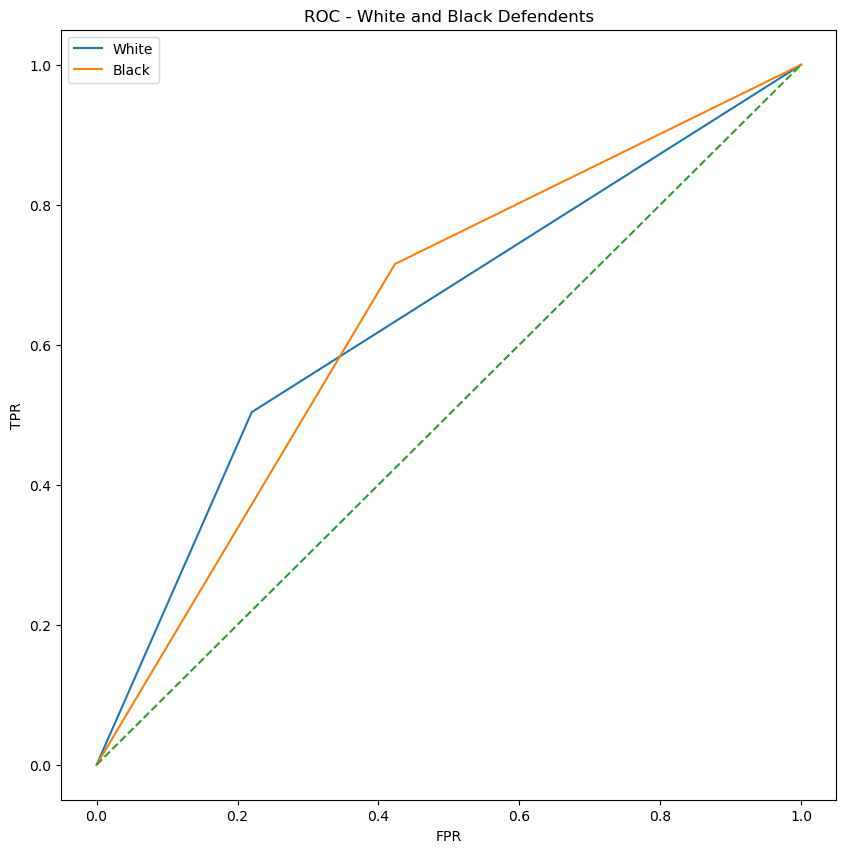

In [118]:
# Calculate FPR and FNR from metrics package - White defendants
white_def = compas[compas["race"] == "Caucasian"]
# True values (if the defendants reoffended)
y2 = white_def['two_year_recid']
# Predicted values from COMPAS tool (risk scores)
pred2 = white_def["decile_score"].replace([1, 2, 3, 4], 0).replace([5, 6, 7, 8, 9, 10], 1)
fpr_white, tpr_white, threshold = roc_curve(y2, pred2)

# Calculate FPR and FNR from metrics package - Black defendants
black_def = compas[compas["race"] == "African-American"]
# True values (if the defendants reoffended)
y1 = black_def['two_year_recid']
# Predicted values from COMPAS tool (risk scores)
pred1 = black_def["decile_score"].replace([1, 2, 3, 4], 0).replace([5, 6, 7, 8, 9, 10], 1)
fpr_black, tpr_black, threshold = roc_curve(y1, pred1)

# Set up the plot for the ROC curve
plt.subplots(1, figsize=(10,10))
plt.title('ROC - White and Black Defendents')
plt.plot(fpr_white, tpr_white)
plt.plot(fpr_black, tpr_black)
plt.plot([0, 1], ls="--")
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend(labels=['White', 'Black'])
plt.show()

In [11]:
# Calculate and print the AUC
print("AUC for White defendants:", roc_auc_score(y2, pred2))
print("AUC for Black defendants:", roc_auc_score(y1, pred1))

AUC for White defendants: 0.641754559907007
AUC for Black defendants: 0.6459250089670798


Another metric that Northpointe uses in their analysis is something called predictive parity, which states that if the Positive Predictive Value (PPV) or Precision is equivalent between groups, then we have predictive parity, and this would indicate fairness. Use the code below to check for predictive parity. 

After this we can look at something called demographic, or statistical, parity. This is simply the proportion that is predicted to recidivate within each group. Northpointe does not make any arguments with respect to this metric, but for completeness we provide it here because it is commonly referred to in the literature.

In [119]:
def prec(race_feature, data):
    # Function returns the Precision for the specified race_feature
    
    subgroup = data[data["race"].isin(race_feature)]
    pred_pos = subgroup[subgroup["decile_score"] > 4]
    recidivated = pred_pos[pred_pos["two_year_recid"] == 1]
    
    return recidivated.shape[0] / pred_pos.shape[0]

def demog(race_feature, data):
    # Function returns statistic needed to check for statistical parity for the specified race_feature
    
    subgroup = data[data["race"].isin(race_feature)]
    pred_pos = subgroup[subgroup["decile_score"] > 4]
    
    return pred_pos.shape[0] / subgroup.shape[0]

# Apply the metrics to the dataset
print("PPV for Black and White defendants:", round(prec(["African-American", "Caucasian"], compas), 5) * 100, "%")
print("PPV for Black defendants:", round(prec(["African-American"], compas), 5) * 100, "%")
print("PPV for white defendants:", round(prec(["Caucasian"], compas), 5) * 100, "%")

print("Demographic Parity for Black and White defendants:", round(demog(["African-American", "Caucasian"], compas), 5) * 100, "%")
print("Demographic Parity for Black defendants:", round(demog(["African-American"], compas), 5) * 100, "%")
print("Demographic Parity for white defendants:", round(demog(["Caucasian"], compas), 5) * 100, "%")

PPV for Black and White defendants: 63.446000000000005 %
PPV for Black defendants: 64.95400000000001 %
PPV for white defendants: 59.483 %
Demographic Parity for Black and White defendants: 47.839999999999996 %
Demographic Parity for Black defendants: 57.606 %
Demographic Parity for white defendants: 33.096 %


<b>Question 3c:</b> What do you notice from the ROC curve, the AUC calculation, the predictive parity calculation, and the demographic parity calculation?

**Answer:** AUC and PPV are approximately the same for both ethinic groups. However, black has greater parity than white.

<b>Question 3d:</b> How would you describe Northpointe’s definition of fairness, after learning and utilizing the metrics they used? How is this different from ProPublica's defintion?

**Answer:** It sums up to what metric you prioritize. Just as there are different metrics (e.g. accuracy, precision, recall, ...) for performance, there are different metrics to measure efficiency of the model. If the population has skewed distribution (e.g. certain age group is predominant, or certain ethnic group has greater population), then FPR and FNR would be more appropriate, while precisioin can be prioritized if population has fairly even distribution.

----

# 4. Removing Disparity <a id="four"></a>

In this section, let's go through yet another metric used to evaluate fairness in machine learning: disparate impact. Disparate impact is a legal doctrine that determines if there is unintended discrimination towards a protected class ([Society for Human Resource Management](https://www.shrm.org/resourcesandtools/tools-and-samples/hr-qa/pages/disparateimpactdisparatetreatment.aspx)). In machine learning, disparate impact is a metric to evaluate fairness in a model when a model’s outputs are dependent on ***sensitive features***. This type of disparate impact is often considered unintentional due to the fact that the sensitive feature may be completely omitted from the model, but is still correlated with the output through proxy variables ([Wang et al.](https://arxiv.org/pdf/1801.05398.pdf#:~:text=Abstract%E2%80%94In%20the%20context%20of,e.g.%2C%20race%20or%20gender)).

Instead of simply evaluating the fairness of the COMPAS tool after the fact, we will notice and remove bias from the dataset to actually change the outputs of the model, and therefore demonstrate another technique aimed at creating a fair algorithm. In order to do so, we need to quantify the disparate impact in the dataset and use `aif360` (a Python package with fairness tools for machine learning) to remove the impact completely. 

Recall the score distributions that we showed above. 

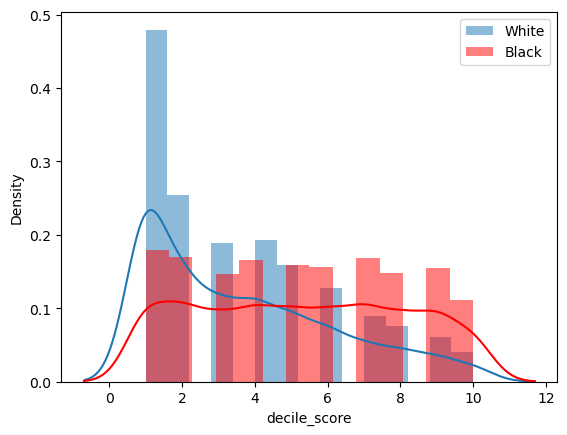

In [121]:
# Code to create a histogram for the risk scores for white defendants
white_data = compas[compas["race"] == "Caucasian"]
sns.histplot(white_data["decile_score"], kde=True, stat="density", kde_kws=dict(cut=3), linewidth=0, label = "White")

# Code to create a histogram for the risk scores for Black defendants
black_data = compas[compas["race"] == "African-American"]
sns.histplot(black_data["decile_score"], kde=True, stat="density", kde_kws=dict(cut=3), linewidth=0, color='r', label = "Black"); # This plot will layer over the previous plot

# Add legend
plt.legend()

# Adjust legend position
plt.legend(loc="upper right")

You should have noted the differences in the distributions between the two groups. This is evidence of disparate impact, but we can further quantify it using what we referred to in class as demographic/statistical parity, along with something called the 4/5ths rule. Essentially, if we identify that the ratio of the proportion of positive predictions (Predicted Positive/(Predicted Positive + Predicted Negative)) in each group is less than 0.8, we can say there is disparate impact because this ratio should be closer to 1 for truly "fair" model (some would say). Let's calculate this below to get a better idea of how it works.

In [122]:
def proportion(data, group):
    # Returns the proportion of individuals from the group who get a high risk score
    race_group = data[data["race"] == group]
    positive_outcomes = race_group[race_group["decile_score"] > 4]
    return len(positive_outcomes) / len(race_group)

In [123]:
# Calculate the disparate impact and interpret using the 4/5th rule
prob_black = proportion(compas, "African-American")
prob_white = proportion(compas, "Caucasian")
prob_white / prob_black

0.5745131730114521

According to the 4/5ths rule, if the proportion is less than 80%, there is a disparate impact violation, which we can see happens here. Note that the denominator of the ratio is the group that had the highest proportion of positive predictions, which in our case is the group of black defendants. This group is sometimes referred to as the "privileged" group, but I've left that language out of this example to avoid confusion.

In order to stop a trained model from replicating this unfairness in its output, we can now use the Python package `aif360`’s Disparate Impact Remover (a tool that was created and designed specifically to eliminate disparate impact in a dataset). The code below does this by creating a specific type of dataset, called a `BinaryLabelDataset` in the package ([documentation for BinaryLabelDataset](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.BinaryLabelDataset.html#aif360.datasets.BinaryLabelDataset)) from our original dataset and creating a `DisparateImpactRemover` type object ([documentation for DisparateImpactRemover](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.DisparateImpactRemover.html)) with the new dataset that eliminates the disparate impact and outputs a transformed dataset. 

You may check the technical details in the paper Certifying and Removing Disparate Impact ([Feldman et al](https://arxiv.org/pdf/1412.3756.pdf)), and also the source code, for how the disparate impact is removed, or *corrected*, but here I will attempt to explain it very simplistically in less mathematical terms. To remove disparate impact, we will only modify the COMPAS scores for each group, and nothing else. We will correct (transform) the scores so that the rank order of the scores within each group **do not change**, the corrected scores will be equal to another score within the dataset (to avoid creating unreasonable or nonexistent scores), and their distributions will be more similar, or even identical, to each other. We do this, using cumulative distribution functions, by finding a new distribution $A$ that will minimize the *sum of the Earth Mover's Distance* between our original distributions and $A$. There are also ways that we can do partial corrections, so that we don't transform the distributions all the way to $A$, and there is an argument in `DisparateImpactRemover` called `repair_level` that controls this.

In [124]:
# Create new DataFrame with just the necessary columns - Only numeric values for race, decile score, and two year recid
race_data = compas[(compas["race"] == "Caucasian") | (compas["race"] == "African-American")]
race_col = pd.get_dummies(race_data, "race")["race_Caucasian"]
noise = np.random.normal(0, 0.01, race_data.shape[0])
decile_col = race_data["decile_score"] + noise
recid_col = race_data["two_year_recid"]
new_df = pd.DataFrame({"race": race_col, "decile_score": decile_col, "two_year_recid": recid_col})

# Create BinaryLabelDataset
BLD = BinaryLabelDataset(favorable_label=1, # Positive Outcome
                         unfavorable_label=0, # Negative Outcome
                         df=new_df,
                         label_names=["two_year_recid"],
                         protected_attribute_names=["race"],
                         unprivileged_protected_attributes=[1])

In [125]:
# repair_level defines the amount of correction we do, and is between 0 (no correction) and 1 (complete correction)
remover = DisparateImpactRemover(repair_level=1, sensitive_attribute="race")
transformed_data = remover.fit_transform(BLD)

Once we've corrected the scores we can plot the new score distributions below to compare to the original score distributions and notice the effectiveness of the disparate impact remover. Remember, only the scores were transformed, but the rank order of the scores, within groups, stayed the same.

Then, we can check the 4/5ths rule to ensure that we no longer have disparate impact in our scores.

In [126]:
# Transform output from DisparateImpactRemover into usable DataFrame
# Use this dataset instead of compas
transformed_df = pd.DataFrame(np.hstack([transformed_data.features, transformed_data.labels]),
                              columns=["race","decile_score","two_year_recid"])
transformed_df["decile_score"] = transformed_df["decile_score"].round()
transformed_df = transformed_df.astype(int)

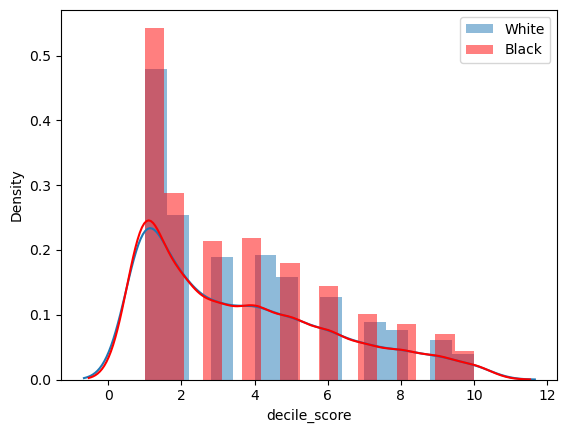

In [128]:
# Code to create a histogram for the risk scores for white defendants
white_data = transformed_df[transformed_df["race"] == 1]
sns.histplot(white_data["decile_score"], kde=True, stat="density", kde_kws=dict(cut=3), linewidth=0, label = "White")

# Code to create a histogram for the risk scores for Black defendants
black_data = transformed_df[transformed_df["race"] == 0]
sns.histplot(black_data["decile_score"], kde=True, stat="density", kde_kws=dict(cut=3), linewidth=0, color='r', label = "Black"); # This plot will layer over the previous plot

# Add legend
plt.legend()

# Adjust legend position
plt.legend(loc="upper right")

In [129]:
# Calculate disparate impact
# Use transformed_df instead of select_data
prob_priv_t = proportion(transformed_df, 0)
prob_unpriv_t = proportion(transformed_df, 1)
prob_unpriv_t / prob_priv_t

0.999795046087484

#### Try a few different values of repair_level and see how the distributions get corrected and how the corresponding disparate impact metric changes.

<b>Question 4a:</b> What has changed from our original histogram? Please explain why this change has happened.

**Answer:** distribution of black changed, and distribution from both ethinic groups look similar.

<b>Question 4b:</b> How would you describe this third definition of fairness, after learning and utilizing these new metrics?

**Answer:** I am skeptical about this method unless this model performs well on the accuracy. Even though the distributions from both ethinic groups look similar, the point of the model is to predict "who is more likely to recidivate?". If the accuracy of the model is sacrified to make the distributions look similar, then the model is wrong.

<!-- END QUESTION -->

------

# 5. Conclusion <a id="five"></a>

We’ve now gone through three definitions of fairness, each one with a different idea of how to operationalize fairness and to judge whether or not an algorithm is fair. As a data scientist, you may encounter situations where you will need to make decisions that affect real-world outcomes and people! Let’s try to do this for COMPAS.

<b>Question 10a:</b> If you had to decide between the three definitions of fairness above, which definition do you think would make “fair” decisions for everyone who goes through the court system? What values did you consider as you made this decision? If you cannot come to a decision, what challenges did you come across when considering this?

**Answer:** (As mentioned above), I would first look at racial and age composition of the defendants. Depending on the distribution, I would use different metric to measure accuracy.

<b>Question 10b:</b> Take a step back and think about how different actors who create, utilize, and are affected by COMPAS would consider which definition is most fair. Name two relevant actors, and discuss what they would value in their own definitions of fairness. Of the three definitions you have explored, which would they decide is most fair from the perspective of that actor? If you don’t think they’d choose any of them, explain why. (Examples of actors, which you’re welcome to use: judges, defendants, police, policy makers, community members)

**Answer:** Defendants prioritize being fairly treated regardless of their race, so would prefer the 3rd model. Policy makers prioritize minimizing recidivism so would prefer the 1st model.

Choosing one definition of fairness can be incredibly difficult when you need to consider all the actors at play. Throughout this module we have examined where and how the COMPAS algorithm is appropriate to use. It is also important to recognize the problems that are not solvable by an algorithm and think through how we can make the ecosystem that COMPAS is in  (which includes but is not limited to the legal system, affected communities, the tech industry, etc.) more just.

You’ve now begun to think through the very complex systems in which the COMPAS algorithm functions. Congratulations! Through considering a few of the differing definitions of fairness connected to COMPAS, hopefully you can begin to understand some of the human contexts of  creating algorithms that intentionally affect people and their decision-making.